## TabNet-Optunaのサンプルコード

In [1]:
%load_ext lab_black

In [2]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# ライブラリーのインポート
import torch
import torch.nn.functional as F
import torch.optim as optim
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import StratifiedKFold
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

%matplotlib inline

import warnings

# Optuna
import optuna
from optuna.samplers import TPESampler

# ボストンの住宅価格データ
from sklearn.datasets import load_boston

# 評価指標
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# 前処理
from sklearn.preprocessing import StandardScaler

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(
    action="ignore", category=pd.core.common.SettingWithCopyWarning
)

In [3]:
print(torch.__version__)

1.9.0+cu102


In [4]:
print(optuna.__version__)

2.8.0


In [5]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


seed_everything(10)

In [6]:
# データセットの読込み
boston = load_boston()

# 説明変数の格納
df = pd.DataFrame(boston.data, columns=boston.feature_names)
# 目的変数の追加
df["MEDV"] = boston.target

# データの中身を確認
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


#### 前処理

In [7]:
# ランダムシード値
RANDOM_STATE = 10

# 学習データと評価データの割合
TEST_SIZE = 0.2

# 学習データと評価データを作成
x_train, x_test, y_train, y_test = train_test_split(
    df.iloc[:, 0 : df.shape[1] - 1],
    df.iloc[:, df.shape[1] - 1],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

# trainのデータセットの2割をモデル学習時のバリデーションデータとして利用する
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [8]:
def objective(trial):

    params = {
        "n_d": trial.suggest_int("n_d", 8, 64),
        "n_a": trial.suggest_int("n_a", 8, 64),
        "n_steps": trial.suggest_int("n_steps", 3, 10),
        "gamma": trial.suggest_loguniform("gamma", 1.0, 2.0),
        "lambda_sparse": trial.suggest_loguniform("lambda_sparse", 1e-4, 1e-2),
        "verbose": 10,
        "optimizer_fn": torch.optim.Adam,
        "optimizer_params": dict(lr=2e-2, weight_decay=1e-5),
        "mask_type": "entmax",
        "scheduler_params": dict(
            max_lr=0.05,
            steps_per_epoch=int(x_train.shape[0] / 256),
            epochs=200,
            is_batch_level=True,
        ),
    }

    model = TabNetRegressor(**params)

    model.fit(
        X_train=x_train.values,
        y_train=y_train.values.reshape(-1, 1),
        eval_set=[(x_valid.values, y_valid.values.reshape(-1, 1))],
        eval_metric=["mae"],
        max_epochs=200,
        patience=20,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=2,
        drop_last=False,
        loss_fn=torch.nn.functional.l1_loss,
    )

    preds = model.predict(x_valid.values)
    mae = mean_absolute_error(y_valid, preds)

    return mae

In [9]:
%%time
# optunaで最適値を見つける
# create_studyメソッドの引数"sampler"にサンプラーと乱数シードを指定
study = optuna.create_study(
    direction="minimize", sampler=TPESampler(seed=RANDOM_STATE)
)
study.optimize(objective, n_trials=10)

[I 2021-08-01 03:32:22,787] A new study created in memory with name: no-name-4bffdf32-ac39-4d90-97a0-9fce37d43fd2


Device used : cpu
epoch 0  | loss: 18.68498| val_0_mae: 328.43533|  0:00:00s
epoch 10 | loss: 5.03933 | val_0_mae: 63.24793|  0:00:10s
epoch 20 | loss: 4.3516  | val_0_mae: 86.41511|  0:00:25s
epoch 30 | loss: 3.03954 | val_0_mae: 14.79323|  0:00:43s
epoch 40 | loss: 4.13435 | val_0_mae: 15.3148 |  0:00:56s
epoch 50 | loss: 2.88944 | val_0_mae: 8.63644 |  0:01:12s
epoch 60 | loss: 3.27153 | val_0_mae: 8.52101 |  0:01:28s
epoch 70 | loss: 2.58074 | val_0_mae: 9.76519 |  0:01:46s

Early stopping occurred at epoch 76 with best_epoch = 56 and best_val_0_mae = 6.66599
Best weights from best epoch are automatically used!


[I 2021-08-01 03:34:18,305] Trial 0 finished with value: 6.665994855503977 and parameters: {'n_d': 51, 'n_a': 9, 'n_steps': 8, 'gamma': 1.6803990584064221, 'lambda_sparse': 0.000993148119483195}. Best is trial 0 with value: 6.665994855503977.


Device used : cpu
epoch 0  | loss: 20.14807| val_0_mae: 138.74709|  0:00:01s
epoch 10 | loss: 4.02662 | val_0_mae: 91.46085|  0:00:12s
epoch 20 | loss: 3.14806 | val_0_mae: 24.54294|  0:00:23s
epoch 30 | loss: 2.77801 | val_0_mae: 21.06122|  0:00:37s
epoch 40 | loss: 2.5662  | val_0_mae: 7.25164 |  0:00:51s
epoch 50 | loss: 2.40684 | val_0_mae: 4.7631  |  0:01:03s
epoch 60 | loss: 1.93986 | val_0_mae: 4.83458 |  0:01:15s
epoch 70 | loss: 1.91277 | val_0_mae: 3.67385 |  0:01:28s
epoch 80 | loss: 2.24673 | val_0_mae: 4.40369 |  0:01:43s
epoch 90 | loss: 1.98907 | val_0_mae: 3.7309  |  0:02:06s
epoch 100| loss: 2.12941 | val_0_mae: 3.40318 |  0:02:19s

Early stopping occurred at epoch 108 with best_epoch = 88 and best_val_0_mae = 2.70801
Best weights from best epoch are automatically used!


[I 2021-08-01 03:36:45,907] Trial 1 finished with value: 2.7080080267823776 and parameters: {'n_d': 20, 'n_a': 19, 'n_steps': 9, 'gamma': 1.1243653010063248, 'lambda_sparse': 0.0001502033532716473}. Best is trial 1 with value: 2.7080080267823776.


Device used : cpu
epoch 0  | loss: 21.40604| val_0_mae: 123.1386|  0:00:01s
epoch 10 | loss: 3.77204 | val_0_mae: 79.2182 |  0:00:11s
epoch 20 | loss: 2.90161 | val_0_mae: 36.54001|  0:00:26s
epoch 30 | loss: 2.22737 | val_0_mae: 32.84702|  0:00:35s
epoch 40 | loss: 2.31192 | val_0_mae: 21.95502|  0:00:54s
epoch 50 | loss: 2.12939 | val_0_mae: 11.65066|  0:01:07s
epoch 60 | loss: 2.21305 | val_0_mae: 9.58677 |  0:01:16s
epoch 70 | loss: 1.66371 | val_0_mae: 8.64855 |  0:01:25s
epoch 80 | loss: 1.58894 | val_0_mae: 6.16464 |  0:01:36s
epoch 90 | loss: 2.03517 | val_0_mae: 6.57984 |  0:01:50s
epoch 100| loss: 1.71578 | val_0_mae: 4.59375 |  0:02:03s
epoch 110| loss: 1.55057 | val_0_mae: 4.092   |  0:02:11s
epoch 120| loss: 1.64315 | val_0_mae: 2.81143 |  0:02:20s
epoch 130| loss: 1.2868  | val_0_mae: 2.86419 |  0:02:29s
epoch 140| loss: 1.50515 | val_0_mae: 2.74299 |  0:02:37s
epoch 150| loss: 1.54351 | val_0_mae: 2.65684 |  0:02:46s
epoch 160| loss: 1.40348 | val_0_mae: 2.46615 |  0:02:

[I 2021-08-01 03:40:13,221] Trial 2 finished with value: 2.092111528655629 and parameters: {'n_d': 47, 'n_a': 62, 'n_steps': 3, 'gamma': 1.4262157719458208, 'lambda_sparse': 0.004219314744806921}. Best is trial 2 with value: 2.092111528655629.


Device used : cpu
epoch 0  | loss: 23.27546| val_0_mae: 156.67833|  0:00:01s
epoch 10 | loss: 3.97387 | val_0_mae: 35.98157|  0:00:11s
epoch 20 | loss: 2.92538 | val_0_mae: 28.09893|  0:00:20s
epoch 30 | loss: 2.47194 | val_0_mae: 24.52693|  0:00:30s

Early stopping occurred at epoch 36 with best_epoch = 16 and best_val_0_mae = 15.95231
Best weights from best epoch are automatically used!


[I 2021-08-01 03:40:50,405] Trial 3 finished with value: 15.952307955423992 and parameters: {'n_d': 42, 'n_a': 49, 'n_steps': 5, 'gamma': 1.8891982739726918, 'lambda_sparse': 0.002686281782188217}. Best is trial 2 with value: 2.092111528655629.


Device used : cpu
epoch 0  | loss: 19.82206| val_0_mae: 131.8155|  0:00:00s
epoch 10 | loss: 4.01586 | val_0_mae: 95.73156|  0:00:08s
epoch 20 | loss: 2.93867 | val_0_mae: 41.18079|  0:00:16s
epoch 30 | loss: 2.48502 | val_0_mae: 31.27241|  0:00:24s
epoch 40 | loss: 2.58106 | val_0_mae: 12.78612|  0:00:34s
epoch 50 | loss: 2.45314 | val_0_mae: 17.25779|  0:00:42s
epoch 60 | loss: 2.16758 | val_0_mae: 11.28636|  0:00:50s
epoch 70 | loss: 2.59355 | val_0_mae: 7.27342 |  0:00:59s
epoch 80 | loss: 2.35187 | val_0_mae: 5.30038 |  0:01:12s
epoch 90 | loss: 2.23975 | val_0_mae: 3.26301 |  0:01:20s
epoch 100| loss: 1.82467 | val_0_mae: 3.76682 |  0:01:29s
epoch 110| loss: 1.86831 | val_0_mae: 4.24867 |  0:01:37s
epoch 120| loss: 1.88791 | val_0_mae: 3.93174 |  0:01:44s
epoch 130| loss: 1.88429 | val_0_mae: 3.43423 |  0:01:52s
epoch 140| loss: 1.70811 | val_0_mae: 3.0176  |  0:02:02s
epoch 150| loss: 1.72786 | val_0_mae: 2.73687 |  0:02:10s
epoch 160| loss: 2.20245 | val_0_mae: 3.20185 |  0:02:

[I 2021-08-01 03:43:21,975] Trial 4 finished with value: 2.391619999026075 and parameters: {'n_d': 38, 'n_a': 16, 'n_steps': 5, 'gamma': 1.595638252662573, 'lambda_sparse': 0.0007650086554079974}. Best is trial 2 with value: 2.092111528655629.


Device used : cpu
epoch 0  | loss: 24.44239| val_0_mae: 66.60385|  0:00:00s
epoch 10 | loss: 4.0323  | val_0_mae: 83.19217|  0:00:12s
epoch 20 | loss: 3.48298 | val_0_mae: 16.47228|  0:00:23s
epoch 30 | loss: 3.01288 | val_0_mae: 5.68572 |  0:00:34s
epoch 40 | loss: 2.79695 | val_0_mae: 11.14833|  0:00:44s
epoch 50 | loss: 2.71454 | val_0_mae: 4.35775 |  0:00:54s
epoch 60 | loss: 2.46581 | val_0_mae: 5.41362 |  0:01:04s
epoch 70 | loss: 2.40591 | val_0_mae: 5.13127 |  0:01:14s

Early stopping occurred at epoch 73 with best_epoch = 53 and best_val_0_mae = 3.73866
Best weights from best epoch are automatically used!


[I 2021-08-01 03:44:40,634] Trial 5 finished with value: 3.7386649826426566 and parameters: {'n_d': 32, 'n_a': 43, 'n_steps': 7, 'gamma': 1.5696002559562134, 'lambda_sparse': 0.0015924943743091898}. Best is trial 2 with value: 2.092111528655629.


Device used : cpu
epoch 0  | loss: 27.81549| val_0_mae: 433.46226|  0:00:01s
epoch 10 | loss: 4.8748  | val_0_mae: 42.6874 |  0:00:15s
epoch 20 | loss: 3.55053 | val_0_mae: 22.95405|  0:00:29s
epoch 30 | loss: 3.60296 | val_0_mae: 26.71067|  0:00:42s

Early stopping occurred at epoch 36 with best_epoch = 16 and best_val_0_mae = 15.21025
Best weights from best epoch are automatically used!


[I 2021-08-01 03:45:32,176] Trial 6 finished with value: 15.21025163156015 and parameters: {'n_d': 53, 'n_a': 37, 'n_steps': 10, 'gamma': 1.2476697293941643, 'lambda_sparse': 0.0001516766396862929}. Best is trial 2 with value: 2.092111528655629.


Device used : cpu
epoch 0  | loss: 22.75276| val_0_mae: 88.09233|  0:00:00s
epoch 10 | loss: 3.73154 | val_0_mae: 55.52167|  0:00:10s
epoch 20 | loss: 2.69351 | val_0_mae: 25.99058|  0:00:19s
epoch 30 | loss: 2.09555 | val_0_mae: 21.46132|  0:00:29s
epoch 40 | loss: 2.50054 | val_0_mae: 13.14493|  0:00:38s
epoch 50 | loss: 2.04166 | val_0_mae: 7.64807 |  0:00:48s
epoch 60 | loss: 2.05892 | val_0_mae: 6.4992  |  0:00:57s
epoch 70 | loss: 2.15868 | val_0_mae: 4.03279 |  0:01:07s
epoch 80 | loss: 2.1916  | val_0_mae: 5.64787 |  0:01:16s
epoch 90 | loss: 1.83206 | val_0_mae: 3.94437 |  0:01:26s
epoch 100| loss: 1.85634 | val_0_mae: 3.5822  |  0:01:35s
epoch 110| loss: 1.75355 | val_0_mae: 3.48351 |  0:01:45s
epoch 120| loss: 1.88192 | val_0_mae: 2.76876 |  0:01:54s
epoch 130| loss: 1.94211 | val_0_mae: 2.48217 |  0:02:04s
epoch 140| loss: 1.76793 | val_0_mae: 2.54515 |  0:02:14s

Early stopping occurred at epoch 145 with best_epoch = 125 and best_val_0_mae = 2.102
Best weights from best ep

[I 2021-08-01 03:47:51,981] Trial 7 finished with value: 2.1019962840610082 and parameters: {'n_d': 25, 'n_a': 14, 'n_steps': 9, 'gamma': 1.0330401446328807, 'lambda_sparse': 0.0017888515294488302}. Best is trial 2 with value: 2.092111528655629.


Device used : cpu
epoch 0  | loss: 22.56101| val_0_mae: 129.09848|  0:00:00s
epoch 10 | loss: 3.30654 | val_0_mae: 35.99973|  0:00:09s
epoch 20 | loss: 2.62379 | val_0_mae: 10.80063|  0:00:19s
epoch 30 | loss: 2.50931 | val_0_mae: 12.17718|  0:00:29s
epoch 40 | loss: 2.15169 | val_0_mae: 9.32896 |  0:00:43s
epoch 50 | loss: 1.92127 | val_0_mae: 7.12111 |  0:01:03s
epoch 60 | loss: 1.82003 | val_0_mae: 7.55108 |  0:01:14s
epoch 70 | loss: 1.72679 | val_0_mae: 6.77197 |  0:01:25s
epoch 80 | loss: 1.70896 | val_0_mae: 4.0371  |  0:01:37s
epoch 90 | loss: 1.9287  | val_0_mae: 3.66728 |  0:01:47s
epoch 100| loss: 1.80972 | val_0_mae: 3.27662 |  0:01:56s
epoch 110| loss: 1.63526 | val_0_mae: 2.89738 |  0:02:05s
epoch 120| loss: 1.49283 | val_0_mae: 2.42564 |  0:02:15s
epoch 130| loss: 1.42895 | val_0_mae: 2.78853 |  0:02:26s
epoch 140| loss: 1.63197 | val_0_mae: 3.20977 |  0:02:36s

Early stopping occurred at epoch 140 with best_epoch = 120 and best_val_0_mae = 2.42564
Best weights from best

[I 2021-08-01 03:50:28,852] Trial 8 finished with value: 2.4256371297954042 and parameters: {'n_d': 39, 'n_a': 54, 'n_steps': 4, 'gamma': 1.8110800342215692, 'lambda_sparse': 0.0005050161641216353}. Best is trial 2 with value: 2.092111528655629.


Device used : cpu
epoch 0  | loss: 16.20612| val_0_mae: 477.2695|  0:00:01s
epoch 10 | loss: 3.39568 | val_0_mae: 73.9404 |  0:00:15s
epoch 20 | loss: 2.69961 | val_0_mae: 16.21145|  0:00:30s
epoch 30 | loss: 3.32229 | val_0_mae: 8.75808 |  0:00:45s
epoch 40 | loss: 2.77602 | val_0_mae: 8.81297 |  0:00:59s

Early stopping occurred at epoch 48 with best_epoch = 28 and best_val_0_mae = 7.88312
Best weights from best epoch are automatically used!


[I 2021-08-01 03:51:40,422] Trial 9 finished with value: 7.8831225618904 and parameters: {'n_d': 51, 'n_a': 24, 'n_steps': 10, 'gamma': 1.2531087627255744, 'lambda_sparse': 0.0002138118619075976}. Best is trial 2 with value: 2.092111528655629.


CPU times: user 20min 44s, sys: 11min 21s, total: 32min 5s
Wall time: 19min 17s


In [10]:
best_params = study.best_params
best_params["verbose"] = 10
best_params["seed"] = RANDOM_STATE
best_params

{'n_d': 47,
 'n_a': 62,
 'n_steps': 3,
 'gamma': 1.4262157719458208,
 'lambda_sparse': 0.004219314744806921,
 'verbose': 10,
 'seed': 10}

In [11]:
# チューニングしたハイパーパラメーターをフィット
optimised_model = TabNetRegressor(**(best_params))

optimised_model.fit(
    X_train=x_train.values,
    y_train=y_train.values.reshape(-1, 1),
    eval_set=[(x_valid.values, y_valid.values.reshape(-1, 1))],
    eval_metric=["mae"],
    max_epochs=200,
    patience=30,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=2,
    drop_last=False,
)

# TabNet推論
y_pred = optimised_model.predict(x_test.values)

Device used : cpu
epoch 0  | loss: 544.70173| val_0_mae: 88.32304|  0:00:00s
epoch 10 | loss: 26.55991| val_0_mae: 88.58951|  0:00:09s
epoch 20 | loss: 16.88512| val_0_mae: 30.38919|  0:00:18s
epoch 30 | loss: 13.73026| val_0_mae: 14.46438|  0:00:27s
epoch 40 | loss: 9.88702 | val_0_mae: 16.33109|  0:00:35s
epoch 50 | loss: 9.76941 | val_0_mae: 10.39402|  0:00:44s
epoch 60 | loss: 7.60929 | val_0_mae: 7.35876 |  0:00:53s
epoch 70 | loss: 10.35971| val_0_mae: 4.43148 |  0:01:02s
epoch 80 | loss: 5.95639 | val_0_mae: 4.6789  |  0:01:12s
epoch 90 | loss: 11.13189| val_0_mae: 3.41289 |  0:01:22s
epoch 100| loss: 7.33472 | val_0_mae: 3.21596 |  0:01:31s
epoch 110| loss: 5.03009 | val_0_mae: 3.11351 |  0:01:40s
epoch 120| loss: 5.88196 | val_0_mae: 2.94373 |  0:01:48s
epoch 130| loss: 5.9392  | val_0_mae: 2.79865 |  0:01:57s
epoch 140| loss: 4.94975 | val_0_mae: 3.16416 |  0:02:06s
epoch 150| loss: 4.07405 | val_0_mae: 2.69989 |  0:02:15s
epoch 160| loss: 4.01065 | val_0_mae: 2.47482 |  0:02

Text(0.5, 1.0, 'feature_importance')

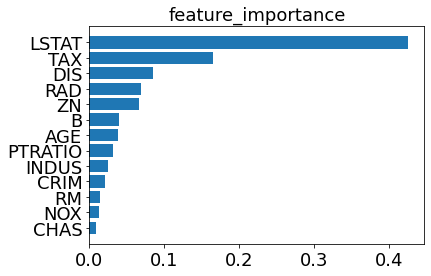

In [12]:
# Feature Importance
feat_imp = pd.DataFrame(
    optimised_model.feature_importances_, index=boston.feature_names
)
feature_importance = feat_imp.copy()

feature_importance["imp_mean"] = feature_importance.mean(axis=1)
feature_importance = feature_importance.sort_values("imp_mean")

plt.tick_params(labelsize=18)
plt.barh(feature_importance.index.values, feature_importance["imp_mean"])
plt.title("feature_importance", fontsize=18)

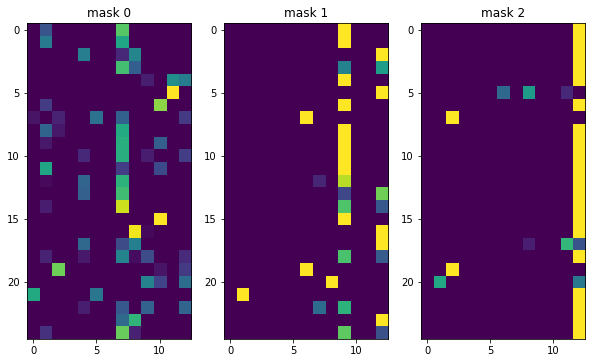

In [13]:
# Mask(Local interpretability)
explain_matrix, masks = optimised_model.explain(x_test.values)

fig, axs = plt.subplots(1, 3, figsize=(10, 7))

for i in range(3):
    axs[i].imshow(masks[i][:25])
    axs[i].set_title(f"mask {i}")

In [14]:
# 評価
def calculate_scores(true, pred):
    """全ての評価指標を計算する

    Parameters
    ----------
    true (np.array)       : 実測値
    pred (np.array)       : 予測値

    Returns
    -------
    scores (pd.DataFrame) : 各評価指標を纏めた結果

    """
    scores = {}
    scores = pd.DataFrame(
        {
            "R2": r2_score(true, pred),
            "MAE": mean_absolute_error(true, pred),
            "MSE": mean_squared_error(true, pred),
            "RMSE": np.sqrt(mean_squared_error(true, pred)),
        },
        index=["scores"],
    )
    return scores

In [15]:
scores = calculate_scores(y_test, y_pred)
print(scores)

              R2       MAE        MSE     RMSE
scores  0.879831  2.516975  12.567379  3.54505
